In [1]:
%run header.py

In [2]:
dask.config.set(scheduler='threading')

In [3]:
import dask_ml
from dask_ml import feature_extraction
from dask_tfidf import DaskTfidfTransformer
import dask.bag as db
import pandas as pd
import random
import scipy.spatial as sp
import numexpr
import plotly_express as px
import sklearn.feature_extraction.text as sktext
numexpr.set_num_threads(1)
import re

In [4]:
ukraine_geo_data = pd.read_html("https://en.wikipedia.org/wiki/List_of_cities_in_Ukraine")[0]
ukraine_cities = ukraine_geo_data['City name'].astype(str)
ukraine_oblasts = ukraine_geo_data['Oblast'].astype(str)
nw = []
for w in ukraine_cities:
  nw.append(w[0:-3] if '[' in w else w)
pattern_str = '|'.join([f'\\b{w}\\b' for w in nw])
pattern_str = r'(?i)' + pattern_str
# pattern = re.compile(pattern_str, flags=re.IGNORECASE)

In [5]:
# full_sample = dd.read_parquet(cleaned_data_path_str + "/*").sample(frac = sampling_rate).dropna().drop_duplicates().persist()
# sample_with_cities = full_sample.text.str.contains(pattern_str)
# ddf = full_sample[sample_with_cities]
# ddf = ddf.sort_values('tweetcreatedts').reset_index(drop = True)
# ddf.persist()

In [6]:
ddf = dd.read_parquet(cleaned_data_path_str + "/*").sample(frac = 0.5).dropna().drop_duplicates().persist()

In [7]:
newsdf = dd.read_csv(news_csv_path_str).dropna()
newsdf['text'] = newsdf['headline'] + ' ' + newsdf['desc']
newsdflen = newsdf.shape[0].compute()
ddflen = ddf.shape[0].compute()

In [8]:
# sample_bag = dask.bag.concat([newsdf.text.to_bag(), ddf.text.to_bag()]).persist()
# vectorizer = dask_ml.feature_extraction.text.HashingVectorizer()
# vecs = vectorizer.fit_transform(sample_bag)
# vecs.persist()
# vecs.compute_chunk_sizes()
# # news_vecs = vecs[-1*newsdflen:].persist()
# # tweet_vecs = vecs[:ddflen].persist()
# tfidf = DaskTfidfTransformer().fit_transform(X = vecs)
# news_tfidf = tfidf[-1*newsdflen:].persist()
# tweet_tfidf = tfidf[:ddflen].persist()

In [9]:
news_articles = pd.read_csv(news_csv_path_str).dropna()
news_articles['text'] = news_articles['headline'] + ' ' + news_articles['desc']

In [10]:
article_dt_ranges = [(date - pd.Timedelta(days = timedelta), date + pd.Timedelta(days = timedelta + 1)) for date in pd.to_datetime(news_articles['date'])]

In [11]:
# i = random.randint(0, len(article_dt_ranges))
i = 184
dl, ul = article_dt_ranges[i]
ddft = ddf.query(f'"{str(str(dl.date()))}" <= tweetcreatedts < "{str(ul.date())}"').repartition(npartitions = 10).drop_duplicates().persist()
news_articles.text[i]

'Russia-Ukraine war: U.S. imposes new sanctions over Russia’s illegal annexation Russian President Vladimir Putin announced the illegal annexation of the Donetsk, Luhansk, Kherson and Zaporizhzhia regions at a ceremony in Moscow. '

In [12]:
import torch
import pyro
import pyro.distributions as dist

In [13]:
tfd = sktext.TfidfVectorizer()
tfd.fit(dd.concat([ddft.text, newsdf.text]))
tweets_tfidf = tfd.transform(ddft.text)
news_tfidf = tfd.transform([news_articles.text[i]])
relevance = news_tfidf.dot(tweets_tfidf.T).toarray().flatten()
dates = ddft.tweetcreatedts.compute().to_numpy()
df = pd.DataFrame({'relevance': relevance, 'date': dates})
rdf = df.assign(relevant = df.relevance > np.quantile(df.relevance, .95))
unscaled = rdf.groupby(pd.Grouper(key = 'date', freq = 'H'))['relevant'].sum().to_frame()

x = rdf.groupby(rdf.date.dt.hour).date.count().to_numpy()
hour_scaler = dict(enumerate(1  + (-1 * ((x - np.mean(x)) / x))))

x = rdf.groupby(rdf.date.dt.dayofweek).date.count().to_numpy()
day_scaler = dict(enumerate(1  + (-1 * ((x - np.mean(x)) / x))))

unscaled['hour_scaler'] = [hour_scaler[x] for x in unscaled.index.hour]
# unscaled['day_scaler'] = [day_scaler[x] for x in unscaled.index.dayofweek]

scaled = unscaled.assign(corrected_relevant = unscaled.relevant * unscaled.hour_scaler)

px.bar(scaled.corrected_relevant)

In [113]:

def piecewise_model(data):
    # Parameters are positive, so we model their logs
    change_point = pyro.sample("change_point", dist.Uniform(0, len(data)))
    
    pre_std = pyro.sample("pre_std", dist.LogNormal(0, 1))
    pre_baseline = pyro.sample("pre_baseline", dist.Normal(torch.mean(data), torch.std(data)))
    
    post_sigma = pyro.sample("post_sigma", dist.LogNormal(0, 1))
    post_baseline = pyro.sample("post_baseline", dist.Normal(torch.mean(data), torch.std(data)))
    relevance_decay = pyro.sample("relevance_decay", dist.LogNormal(0, 1))
    
    with pyro.plate("data", len(data)) as inds:

            
        # pre_idx = torch.arange(len(data)) < change_point
        # pyro.sample("pre_obs", dist.Normal(pre_baseline, pre_std), obs=data[pre_idx])
        
        # post_idx = torch.arange(len(data)) >= change_point
        
        # # Adjust post_means calculation to only consider the range after the change_point
        # adjusted_times = torch.arange(len(data))[post_idx] - change_point
        # post_means = torch.exp(-1 * relevance_decay * adjusted_times.float()) + post_baseline
        
        # pyro.sample("post_obs", dist.Normal(post_means, post_sigma), obs=data[post_idx])
        
        for i in range(len(data)):
            if i < change_point:
                pyro.sample(f"pre_obs_{i}", dist.Normal(pre_baseline, pre_std), obs=data[i])
            else:
                adjusted_time = i - change_point
                post_mean = torch.exp(-1 * relevance_decay * adjusted_time) + post_baseline
                # print(post_mean, post_sigma, data[i])
                pyro.sample(f"post_obs_{i}", dist.Normal(post_mean, post_sigma), obs=data[i])

In [94]:
import torch
import pyro
import pyro.distributions as dist

def vectorized_piecewise_model(data):
    # Parameters are positive, so we model their logs
    change_point = pyro.sample("change_point", dist.Uniform(0, len(data)))
    
    pre_std = pyro.sample("pre_std", dist.LogNormal(0, 1))
    pre_baseline = pyro.sample("pre_baseline", dist.Normal(torch.mean(data), torch.std(data)))
    
    post_sigma = pyro.sample("post_sigma", dist.LogNormal(0, 1))
    post_baseline = pyro.sample("post_baseline", dist.Normal(torch.mean(data), torch.std(data)))
    relevance_decay = pyro.sample("relevance_decay", dist.Poisson(1))
    
    with pyro.plate("data", len(data)) as index:
        time_index = index.float()
        
        # Compute condition masks
        pre_mask = time_index < change_point
        post_mask = time_index >= change_point
        
        # Compute the post_means for all time points in one go
        adjusted_times = time_index - change_point
        post_means = torch.exp(-relevance_decay * adjusted_times) * post_mask + post_baseline
        
        print(post_means)
        
        # Observations
        obs = data[index]
        
        # Pre-change observations
        pre_obs = pyro.sample("pre_obs", dist.Normal(pre_baseline.expand_as(obs), pre_std), obs=obs * pre_mask)
        
        # Post-change observations
        post_obs = pyro.sample("post_obs", dist.Normal(post_means, post_sigma), obs=obs * post_mask)


In [45]:
vectorized_piecewise_model(torch.from_numpy(scaled.corrected_relevant.to_numpy()))

In [115]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDiagonalNormal
import torch

# Assume `vectorized_piecewise_model` is defined as above

# Define the guide (approximate posterior)
guide = AutoDiagonalNormal(piecewise_model)

# Setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# Setup the inference algorithm
svi = SVI(piecewise_model, guide, optimizer, loss=TraceGraph_ELBO())

# Assume you have your data in a PyTorch tensor called `data`
data = torch.from_numpy(scaled.corrected_relevant.to_numpy()) # Example data

# piecewise_model(data)
# loss = svi.step(data)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Calculate the loss and take a gradient step
    loss = svi.step(data)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss}")

# # After training, you can extract the learned parameters
learned_params = guide.median()
# print(learned_params)

Epoch 0: Loss = 8038534.0


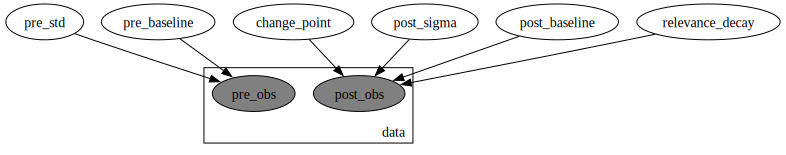

In [46]:
pyro.render_model(vectorized_piecewise_model, model_args=(torch.from_numpy(scaled.corrected_relevant.to_numpy()),))

In [17]:
# import ruptures as rpt

In [18]:
# temp = ddft.tweetcreatedts.compute().diff()
# intervals = temp.values.astype('float')
# model = 'rbf'
# algo = rpt.Pelt(model=model)
# result = algo.fit_predict(intervals[1:], pen=4)
# subsections = []
# prev = 0
# for k in result:
#     subsections.append(range(prev,k))
#     prev = k
# # subsections
# splitter = np.argmin(np.abs([np.mean(s) for s in np.split(intervals[1:], result[:-1])]))#np.argmin([np.mean(s) for s in np.split(intervals[1:], result[:-1])])
# splitter = subsections[splitter][0]

In [19]:
# splitter